In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from data_process.column_schema import PROPERTIES_RENAME_DICT, TRANSACTION_RENAME_DICT, NUMERICAL_COLS
from data_process.data_process_pipeline import DataProcessPipeline
from models.nn_models.dnn import DNN
from models.hyperparameter_opt import HyperParameterOpt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_all = pd.read_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/df_merged.csv')

In [3]:
data_pipeline = DataProcessPipeline(categorical_cols=[])

In [4]:
df = data_pipeline.pre_process(df_all)

In [21]:
space = dict()
space['learning_rate'] = hp.loguniform('learning_rate', -4*np.log(10), -1*np.log(10))
space['reg'] = hp.loguniform('reg', -4*np.log(10), -1*np.log(10))
# space['dim_hidden_lst'] = hp.choice('dim_hidden_lst', [(20,), (30,)])
space['decay'] = hp.loguniform('decay', -1*np.log(10), -3*np.log(10))

hyper_opt = HyperParameterOpt(model_class=DNN, data_process_pipeline=data_pipeline, df=df, 
                              search_space=space, max_evals=10,
                              fixed_params={'dim_inputs': len(data_pipeline.numerical_cols),
                                            'dim_hidden_lst': [30]})

In [ ]:
hyper_opt.optimize(52)

In [ ]:
hyper_opt.trial_results

In [24]:
iterator = data_pipeline.k_fold(df, 52)

In [25]:
df_train, df_val = iterator.next()

In [26]:
df_train = data_pipeline.post_process(df_train, is_train=True)
df_val = data_pipeline.post_process(df_val, is_train=False)

In [27]:
X_train = df_train[data_pipeline.numerical_cols].values
y_train = df_train[data_pipeline.label_col].values
X_val = df_val[data_pipeline.numerical_cols].values
y_val = df_val[data_pipeline.label_col].values

In [28]:
model = DNN(dim_inputs=len(data_pipeline.numerical_cols), dim_hidden_lst=[30], 
            learning_rate=0.01, decay=0.01,
            batch_size=128, epochs=5, verbose=2)

In [31]:
model.fit(X=X_train, y=y_train)

Epoch 1/5
1s - loss: 0.0295 - mean_absolute_error: 0.0702
Epoch 2/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688
Epoch 3/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688
Epoch 4/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688
Epoch 5/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688


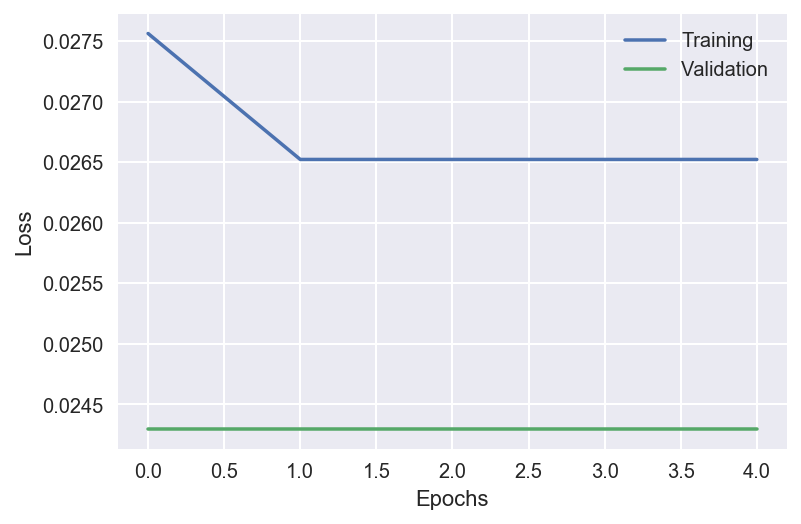

In [59]:
model.plot_train_history()

In [64]:
model.train_history.history['val_mean_absolute_error'][-1]

0.06723140943326042

# Hyperopt

In [63]:
space = {}
space['learning_rate'] = hp.loguniform('learning_rate', -4*np.log(10), -1*np.log(10))

In [65]:
def objective(params):
    model = DNN(dim_inputs=len(data_pipeline.numerical_cols), dim_hidden_lst=[30], decay=0.01,
                batch_size=128, epochs=5, verbose=2, **params)
    data_pipeline.k_fold(df, 52)
    
    model.fit(X_train, y_train, X_val=X_val, y_val=y_val)
    # modify values returned here to include more information
    return model.train_history.history['val_mean_absolute_error'][-1]

In [67]:
trials = Trials()

In [68]:
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

Train on 72220 samples, validate on 18055 samples
Epoch 1/5
1s - loss: 0.0349 - mean_absolute_error: 0.0701 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 2/5
1s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 3/5
1s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 4/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 5/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Train on 72220 samples, validate on 18055 samples
Epoch 1/5
1s - loss: 0.0353 - mean_absolute_error: 0.0744 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 2/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 3/5
0s - loss: 0.0265 - mean_absolute_error: 0.0688 - val_loss: 0.0243 - val_mean_absolute_error: 0.0672
Epoch 4/5
0s

In [69]:
best

{'learning_rate': 0.015781770035133494}

In [72]:
best_params = space_eval(space, best)

In [73]:
best_params

{'learning_rate': 0.015781770035133494}

In [78]:
trials.trials[0]

{'book_time': datetime.datetime(2017, 7, 23, 18, 30, 24, 392000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'learning_rate': [0]},
  'tid': 0,
  'vals': {'learning_rate': [0.015781770035133494]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 7, 23, 18, 30, 30, 98000),
 'result': {'loss': 0.06723140943326042, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}